## <b><span style='color:#F1C40F'>|</span> Preprocess</b>

In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
import os
import pandas as pd
import numpy as np
import tensorflow as tf

api = KaggleApi()
api.authenticate()

In [2]:
for file in ['train.tsv', 'test.tsv']:
    api.competition_download_file('sentiment-analysis-on-movie-reviews', f'{file}.zip', path='./')

    with zipfile.ZipFile(f'{file}.zip', 'r') as zip_ref:
        zip_ref.extractall('./data')

    os.remove(f'{file}.zip')

100%|██████████| 1.28M/1.28M [00:00<00:00, 1.35MB/s]


100%|██████████| 494k/494k [00:00<00:00, 786kB/s]

In [3]:
df = pd.read_csv('./data/train.tsv', sep='\t')
df

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [4]:
df.drop_duplicates(subset=['SentenceId'], keep='first')

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1
...,...,...,...,...
155984,155985,8540,... either you 're willing to go with this cla...,2
155997,155998,8541,"Despite these annoyances , the capable Claybur...",2
156021,156022,8542,-LRB- Tries -RRB- to parody a genre that 's al...,1
156031,156032,8543,The movie 's downfall is to substitute plot fo...,1


The sentiment labels are:

    0 - negative
    1 - somewhat negative
    2 - neutral
    3 - somewhat positive
    4 - positive

<Axes: xlabel='Sentiment'>

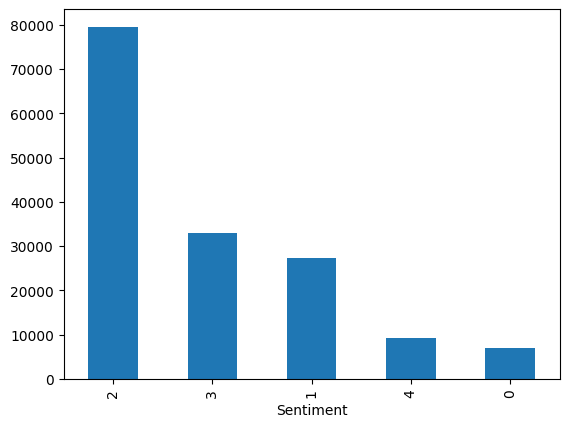

In [5]:
df['Sentiment'].value_counts().plot(kind='bar')

In [6]:
seq_len = 512
num_samples = len(df)

print('Number of samples: {}, seq len: {}'.format(num_samples, seq_len))

Number of samples: 156060, seq len: 512


In [7]:
from transformers import BertTokenizer

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [9]:
tokens = tokenizer(df['Phrase'].tolist(), 
                   max_length=seq_len, 
                   truncation=True,
                   padding='max_length', 
                   add_special_tokens=True,
                   return_tensors='np')

In [10]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [11]:
tokens['input_ids']

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]])

In [12]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [13]:
with open('./data/movie-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])

with open('./data/movie-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [14]:
arr = df['Sentiment'].values
arr.shape

(156060,)

In [15]:
arr

array([1, 2, 2, ..., 3, 2, 2], dtype=int64)

    2 = [0, 0, 1, 0, 0]
    4 = [0, 0, 0, 0, 1]

In [16]:
labels = np.zeros((num_samples, arr.max() + 1))
labels.shape

(156060, 5)

In [17]:
labels[np.arange(num_samples), arr] = 1
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [18]:
with open('./data/movie-labels.npy', 'wb') as f:
    np.save(f, labels)

## <b><span style='color:#F1C40F'>|</span>Input pipeline</b>

In [19]:
with open('./data/movie-xids.npy', 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open('./data/movie-xmask.npy', 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open('./data/movie-labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

In [20]:
Xids.shape

(156060, 512)

In [21]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [22]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

{input_ids, attention_mask}, outputs

In [23]:
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids,
            'attention_mask': masks}, labels

In [24]:
dataset = dataset.map(map_func)
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [25]:
batch_size = 16
split = 0.9

In [26]:
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [27]:
size = int((Xids.shape[0] / batch_size) * split)
size

8778

In [28]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

del dataset

In [29]:
tf.data.experimental.save(train_ds, '/train')
tf.data.experimental.save(val_ds, '/val')

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


In [30]:
train_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None),
  'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [31]:
train_ds.element_spec == val_ds.element_spec

True

In [32]:
ds = tf.data.experimental.load('/train', element_spec=train_ds.element_spec)
ds.take(1)

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

## <b><span style='color:#F1C40F'>|</span>Build and train</b>

In [33]:
from transformers import TFAutoModel

In [34]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

# we can view the model using the summary method
bert.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108310272 (413.17 MB)
Trainable params: 108310272 (413.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access final activations (alread max-pooled) [1]
# convert bert embeddings into 5 output classes
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

In [36]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# (optional) freeze bert layer
model.layers[2].trainable = False

# print out model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  


 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 512, 7                                           
                             68),                                                                 
                              pooler_output=(None, 768)                                           
                             , past_key_values=None, hi                                           
                             dden_states=None, attentio                                           
                             ns=None, cross_attentions=                                           
                             None)                                                                
                                                                                                  
 dense (De

In [37]:
model.layers[2].trainable = False

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 512, 7                                       

In [39]:
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [40]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.int32, name=None),
                 'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)},
                tf.TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

# load the training and validation sets
train_ds = tf.data.experimental.load('/train', element_spec=element_spec)
val_ds = tf.data.experimental.load('/val', element_spec=element_spec)

# view the input format
train_ds.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

## It takes a lot of computing power to do this, I don't have that much

In [41]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3



 170/8778 [..............................] - ETA: 21:29:10 - loss: 1.3201 - accuracy: 0.5121

KeyboardInterrupt: 

In [ ]:
model.save('sentiment_model')

## <b><span style='color:#F1C40F'>|</span>Load and predict</b>

In [ ]:
model = tf.keras.models.load_model('sentiment_model')
model.summary()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

In [ ]:
probs = model.predict(prep_data("hello world"))[0]
probs

In [ ]:
np.argmax(probs)

In [ ]:
pd.set_option('display.max_colwidth', None)

df = pd.read_csv('./data/test.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine effort .
1,156062,8545,An intermittently pleasing but mostly routine effort
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [ ]:
df = df.drop_duplicates(subset=['SentenceId'], keep='first')
df.head()

In [ ]:
df['Sentiment'] = None

for i, row in df.iterrows():
    # get token tensors
    tokens = prep_data(row['Phrase'])
    # get probabilities
    probs = model.predict(tokens)
    # find argmax for winning class
    pred = np.argmax(probs)
    # add to dataframe
    df.at[i, 'Sentiment'] = pred

df.head()

In [ ]:
df.tail()